<a href="https://colab.research.google.com/github/LuidDuarte/PPD-UFSCar-2022/blob/main/PPD2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Filtro Gaussiano
## Convolução de uma imagem com um kernel 5x5 gaussiano

 - o tipo de imagem utilizado para os códigos é o "PGM" devido a facilidade de leitura em um código em C, não necessitando fazer decode, ele por padrão contém um header indicando "PGM" seu tamano em linha x coluna e o valor máximo do pixel, além de ser em gray scale por default
    - [Pasta no G Drive com as imagens](https://drive.google.com/drive/folders/119XO6H8ue1qUQRD6igM8WOQtLtAJDSsn?usp=sharing)


###Metodos para auxiliar na visualização dos resultados:

In [5]:
args = [("cameraman1.pgm", "cameraman_saida.pgm"),
        ("cat1.pgm", "cat1_saida.pgm"),
        ("cat2.pgm", "cat2_saida.pgm"),
        ("8k.pgm", "8k_saida.pgm")]

def plotar_imagens(images):
  import matplotlib.pyplot as plt
  f = plt.figure(dpi=200)
  for i, imagem in enumerate(images):
    img_f = open(imagem, 'rb')
    a = f.add_subplot(1,2,i+1)
    im = plt.imread(img_f)
    a.set_title(imagem)
    plt.imshow(im, cmap='gray')
  plt.show(block=True)

def limpa_arquivos_de_saida():
  import os
  files = os.listdir()
  for file_ in files:
    if ".o" in file_ or "_saida.pgm" in file_:
      os.remove(file_)


###Sequencial:

####Código:

In [1]:
%%writefile convolucao_seq.c
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <time.h>

void convolution(int altura, int largura, short int mask[25], unsigned char *original, unsigned char *resultado){  
    int i, j, aux_i, aux_j;
    int pixel_resultante;
    int p, q; // for interno, da mascara 3x3
    for(i = 0; i < altura; i++){
        for(j = 0; j < largura; j++){
            pixel_resultante = 0;
            aux_i = i; 
            for(p = 0; p < 5; p++){
                aux_j = j;
                for(q = 0; q < 5; q++){
                    pixel_resultante += original[aux_i*largura + aux_j] * mask[p*5 + q];
                    aux_j++;
                }                    
                aux_i++;
            }
            //por estarmos utilizando uma matriz 5x5 de gauss, após a soma das multiplicações devemos dividir por 273
            resultado[i*largura + j] = pixel_resultante/273;
        }
    }
}

int main(int argc, char **argv){
    FILE *imagem;
    FILE *nova_imagem;
    char *nome_imagem;
    char *nome_imagem_saida;
    char key[128];
    int i, j, largura, altura, max, pixel_resultante, threshold;


    if (argc != 3){
        printf("Erro, o programa deve receber o nome da imagem de entrada \n"
                "e um nome para imagem de saida.");
        return 0;
    }

    nome_imagem = argv[1];
    nome_imagem_saida = argv[2];

    imagem = fopen(nome_imagem , "r") ; // Abre o arquivo no modo leitura
    if(imagem == NULL){ // Verifica se o arquivo existe e foi aberto
        printf("Erro na abertura do arquivo %s\n", nome_imagem);
        return 0;
    }

    // Le cabecalho
    fscanf(imagem, "%s", key);

    // Imagens PGM tem "P5" na primeira linha
    if(strcmp(key,"P5") != 0){
        printf("Arquivo precisa ser PGM!\n") ;
        fclose(imagem);
        return 0;
    }

    //Próximos valores do cabeçalho após P5 são: numero de colunas, numero de linhas, e valor máximo.
    fscanf(imagem, "%d %d %d", &largura, &altura, &max) ;

    // Matriz para guardar a imagem original
    // Utilizando o método de bordas "pretas"
    unsigned char *original;
    int n_col = largura+2;
    int n_row = altura+2;
    original = (unsigned char*) malloc(n_row * n_col * sizeof(unsigned char*));


    // Matriz pra servir de buffer pra imagem resultado
    unsigned char *resultado;
    resultado = (unsigned char*) malloc(altura * largura *sizeof(unsigned char*));


    // Leitura da imagem original
    for(i = 1; i < altura+1; i++){
        for(j = 1; j < largura+1; j++){
            fscanf(imagem, "%c", &original[i*largura + j]);
        }
    }

    // matriz de convolução gaussiana
    //gaus 5x5
    short int mask[25] = {1,  4,  7,  4, 1, 
                          4, 16, 26, 16, 4, 
                          7, 26, 41, 26, 7, 
                          4, 16, 26, 16, 4, 
                          1,  4,  7,  4, 1};

    // abrir nova imagem em modo de escrita e "copiar" o cabeçalho da imagem original
    nova_imagem = fopen(nome_imagem_saida , "w");
    fprintf(nova_imagem,"P5\n%d %d\n%d\n", largura, altura, max);

    float etime;
    struct timespec inic, fim;

    clock_gettime(CLOCK_REALTIME, &inic);

    convolution(altura, largura, mask, original, resultado);

    clock_gettime(CLOCK_REALTIME, &fim);

    // tempo decorrido: elapsed time
    etime = (fim.tv_sec + fim.tv_nsec/1000000000.) - 
            (inic.tv_sec + inic.tv_nsec/1000000000.) ;

    printf("Tempo da convolução: %lf\n", etime);
    printf("Altura: %d\tLargura: %d\n", altura ,largura);

    // escrever no arquivo resultado
    for (i = 0; i < altura ; i++){
        for (j = 0; j < largura; j++){
            fprintf(nova_imagem, "%c", resultado[i*largura + j]);
        }
    }
    //fputs(resultado, nova_imagem);
    
    fclose(imagem);
    fclose(nova_imagem);

    free(original);
    free(resultado);

    return 0;
}

Writing convolucao_seq.c


####Execução:

Tempo da convolução: 0.199507
Altura: 1602	Largura: 1200

real	0m0.306s
user	0m0.294s
sys	0m0.006s


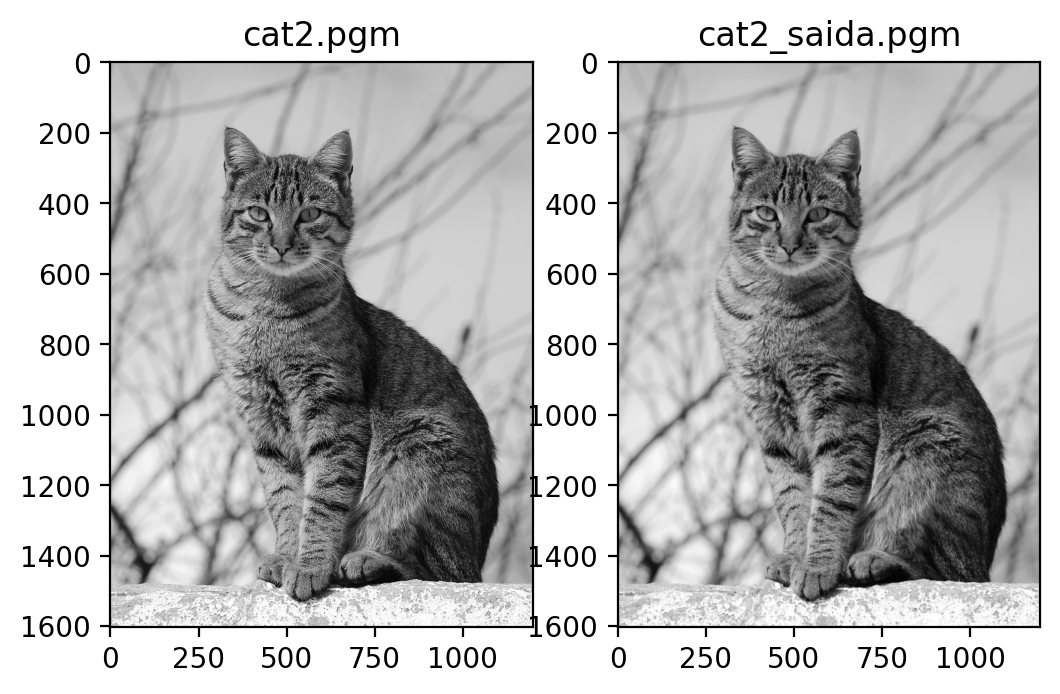

In [18]:
input, output = args[2]
limpa_arquivos_de_saida()
! gcc convolucao_seq.c -o seq.o && time ./seq.o $input $output

plotar_imagens((input, output))

### OpenMP

#### Código

In [ ]:
%%writefile convolucao_openmp.c
#include <omp.h> 
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <time.h>

void convolution(int altura, int largura, short int mask[25], unsigned char *original, unsigned char *resultado){  
    int i, j, aux_i = 0, aux_j = 0;
    int pixel_resultante;
    int p, q; // for interno, da mascara 5x5


    #pragma omp parallel for  private(pixel_resultante, j, p, q, aux_i, aux_j)
    for(i = 0; i < altura; i++){
        for(j = 0; j < largura; j++){
            pixel_resultante = 0;
            aux_i = i; 
            for(p = 0; p < 5; p++){
                aux_j = j;
                for(q = 0; q < 5; q++){
                    pixel_resultante += original[aux_i*largura + aux_j] * mask[p*5 + q];
                    aux_j++;
                }                    
                aux_i++;
            }
            
            //por estarmos utilizando uma matriz 5x5 de gauss, após a soma das multiplicações devemos dividir por 273
            resultado[i*largura + j] = pixel_resultante/273;
        }
    }

}


int main(int argc, char **argv){
    FILE *imagem;
    FILE *nova_imagem;
    char *nome_imagem;
    char *nome_imagem_saida;
    char key[128];
    int i, j, largura, altura, max, pixel_resultante, threshold;


    if (argc != 3){
        printf("Erro, o programa deve receber o nome da imagem de entrada \n"
                "e um nome para imagem de saida.");
        return 0;
    }

    nome_imagem = argv[1];
    nome_imagem_saida = argv[2];

    imagem = fopen(nome_imagem , "r") ; // Abre o arquivo no modo leitura
    if(imagem == NULL){ // Verifica se o arquivo existe e foi aberto
        printf("Erro na abertura do arquivo %s\n", nome_imagem);
        return 0;
    }

    // Le cabecalho
    fscanf(imagem, "%s", key);

    // Imagens PGM tem "P5" na primeira linha
    if(strcmp(key,"P5") != 0){
        printf("Arquivo precisa ser PGM!\n") ;
        fclose(imagem);
        return 0;
    }

    //Próximos valores do cabeçalho após P5 são: numero de colunas, numero de linhas, e valor máximo.
    fscanf(imagem, "%d %d %d", &largura, &altura, &max) ;

    // Matriz para guardar a imagem original
    // Utilizando o método de bordas "pretas"
    unsigned char *original;
    int n_col = largura+2;
    int n_row = altura+2;
    original = (unsigned char*) malloc(n_row * n_col * sizeof(unsigned char*));


    // Matriz pra servir de buffer pra imagem resultado
    unsigned char *resultado;
    resultado = (unsigned char*) malloc(altura * largura *sizeof(unsigned char*));


    // Leitura da imagem original
    for(i = 1; i < altura+1; i++){
        for(j = 1; j < largura+1; j++){
            fscanf(imagem, "%c", &original[i*largura + j]);
        }
    }

    // matriz de convolução gaussiana
    //gaus 5x5
    short int mask[25] = {1,  4,  7,  4, 1, 
                          4, 16, 26, 16, 4, 
                          7, 26, 41, 26, 7, 
                          4, 16, 26, 16, 4, 
                          1,  4,  7,  4, 1};

    // abrir nova imagem em modo de escrita e "copiar" o cabeçalho da imagem original
    nova_imagem = fopen(nome_imagem_saida , "w");
    fprintf(nova_imagem,"P5\n%d %d\n%d\n", largura, altura, max);

    float etime;
    struct timespec inic, fim;

    clock_gettime(CLOCK_REALTIME, &inic);

    convolution(altura, largura, mask, original, resultado);

    clock_gettime(CLOCK_REALTIME, &fim);

    // tempo decorrido: elapsed time
    etime = (fim.tv_sec + fim.tv_nsec/1000000000.) - 
            (inic.tv_sec + inic.tv_nsec/1000000000.) ;

    printf("Tempo da convolução: %lf\n", etime);
    printf("Altura: %d\tLargura: %d\n", altura ,largura);

    // escrever no arquivo resultado
    for (i = 0; i < altura ; i++){
        for (j = 0; j < largura; j++){
            fprintf(nova_imagem, "%c", resultado[i*largura + j]);
        }
    }
    //fputs(resultado, nova_imagem);
    
    fclose(imagem);
    fclose(nova_imagem);

    free(original);
    free(resultado);

    return 0;
// speedup = 0.005124 / 0.001442 = 3.55
// eficiencia = 3.55 / 4 = 0.88

}

Writing convolucao_openmp.c


#### Execução:

Tempo da convolução: 0.013212
Altura: 256	Largura: 256

real	0m0.027s
user	0m0.025s
sys	0m0.003s


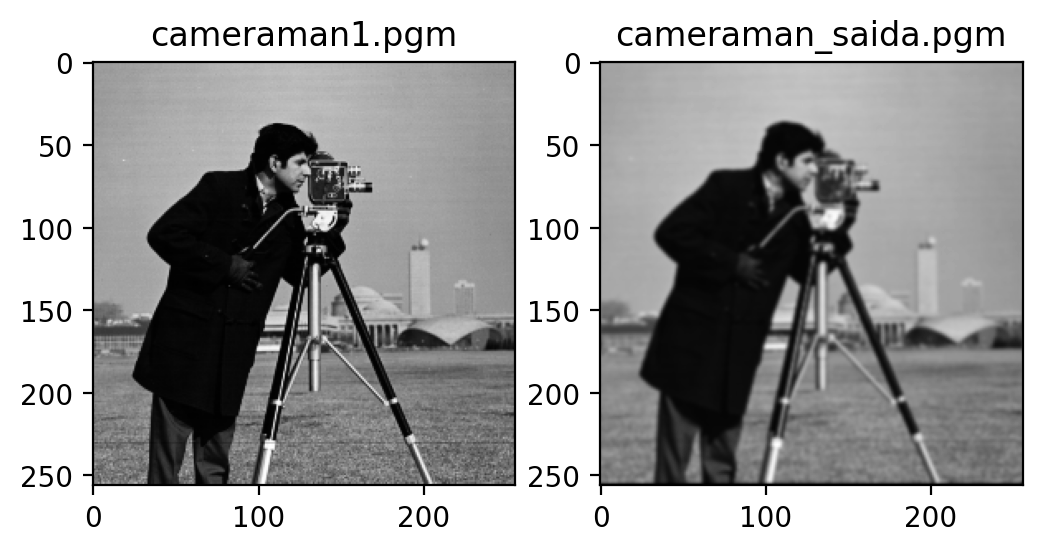

In [ ]:
input, output = args[0]
limpa_arquivos_de_saida()
!gcc convolucao_openmp.c -o convolucao_openmp -fopenmp 
!time ./convolucao_openmp $input $output

plotar_imagens((input, output))

### MPI:

#### Código:

In [ ]:
%%writefile convolucao_mpi.c
#include <stdio.h>
#include <math.h>
#include <stdlib.h>
#include <string.h>
#include <time.h>
#include "mpi.h"

struct info {
    int lin, col;
    int tam_lin, tam_col;
} t_info;

struct r_info {
    int lin, col;
    int tam_lin, tam_col;
} r_info;

void mpi_convolution(int altura, int largura, int offset_altura, int offset_largura, int tamanho_secao_altura, int tamanho_secao_largura, short int mask[25], unsigned char *original, unsigned char *resultado){  
    int i, j, aux_i, aux_j, ii, jj;
    int pixel_resultante;
    int p, q;


    for(i = offset_altura; i < offset_altura + tamanho_secao_altura; i++){
        for(j = offset_largura; j < offset_largura + tamanho_secao_largura; j++){
            pixel_resultante = 0;
            aux_i = i; 
            for(p = 0; p < 5; p++){
                aux_j = j;
                for(q = 0; q < 5; q++){
                    pixel_resultante += original[aux_i*largura + aux_j] * mask[p*5 + q];
                    aux_j++;
                }                    
                aux_i++;
            }
            //por estarmos utilizando uma matriz 5x5 de gauss, após a soma das multiplicações devemos dividir por 273
            ii = i - offset_altura;
            jj = j - offset_largura;
            resultado[ii*tamanho_secao_largura + jj] = pixel_resultante/273;
        }
    }
}


int main(int argc, char **argv){
    FILE *imagem;
    char *nome_imagem;
    char *nome_imagem_saida;
    char key[128];
    int i, j, largura, altura, max, pixel_resultante, threshold;

    /* -- MPI -- */
    int numtasks, rank;
    int t, result;
    /* -- MPI -- */


    if (argc != 3){
        printf("Erro, o programa deve receber o nome da imagem de entrada \n"
                "e um nome para imagem de saida.");
        return 0;
    }

    nome_imagem = argv[1];
    nome_imagem_saida = argv[2];

    imagem = fopen(nome_imagem , "r") ; // Abre o arquivo no modo leitura
    if(imagem == NULL){ // Verifica se o arquivo existe e foi aberto
        printf("Erro na abertura do arquivo %s\n", nome_imagem);
        return 0;
    }

    // Le cabecalho
    fscanf(imagem, "%s", key);

    // Imagens PGM tem "P5" na primeira linha
    if(strcmp(key,"P5") != 0){
        printf("Arquivo precisa ser PGM!\n") ;
        fclose(imagem);
        return 0;
    }

    //Próximos valores do cabeçalho após P5 são: numero de colunas, numero de linhas, e valor máximo.
    fscanf(imagem, "%d %d %d", &largura, &altura, &max) ;

    // Matriz para guardar a imagem original
    // Utilizando o método de bordas "pretas"
    unsigned char *original;
    int n_col = largura+2;
    int n_row = altura+2;
    original = (unsigned char*) malloc(n_row * n_col * sizeof(unsigned char*));


    // Leitura da imagem original
    for(i = 1; i < altura+1; i++){
        for(j = 1; j < largura+1; j++){
            fscanf(imagem, "%c", &original[i*largura + j]);
        }
    }

    // matriz de convolução gaussiana
    //gaus 5x5
    short int mask[25] = {1,  4,  7,  4, 1, 
                          4, 16, 26, 16, 4, 
                          7, 26, 41, 26, 7, 
                          4, 16, 26, 16, 4, 
                          1,  4,  7,  4, 1};



    float etime;
    struct timespec inic, fim;
    clock_gettime(CLOCK_REALTIME, &inic);

    /* -- MPI -- */
    result = MPI_Init(&argc, &argv);
    if (result != MPI_SUCCESS) {
        fprintf(stderr, "Erro iniciando MPI: %d\n", result)/
        MPI_Abort(MPI_COMM_WORLD, result);
    }
    MPI_Comm_size(MPI_COMM_WORLD, &numtasks);
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);


    if (rank == 0) {
        setbuf(stdout,NULL);
        
        double tamanho_quadrado = sqrt((altura * largura) / (numtasks - 1.0));
        if (trunc(tamanho_quadrado) != tamanho_quadrado)
        {
            printf("Não é possível dividir a imagem em quadrados\n");
            exit(1);
        }
        // int tamanho_secao_altura = altura / ((numtasks - 1)/2);
        // int tamanho_secao_largura = largura / ((numtasks - 1)/2);
        int tamanho_secao_altura = (int) tamanho_quadrado;
        int tamanho_secao_largura = (int) tamanho_quadrado;

        t_info.lin = 0;
        t_info.col = 0;
        t_info.tam_lin = tamanho_secao_altura;
        t_info.tam_col = tamanho_secao_largura;

        // Enviando offsets das imagens
        for (t = 1; t < numtasks; t++) {
           MPI_Send ( &t_info, sizeof(t_info), MPI_INT, t, 1, MPI_COMM_WORLD); 
           if (t_info.lin < (altura - tamanho_secao_altura)) {
               t_info.lin += tamanho_secao_altura;
           } else {
               t_info.lin = 0;
               t_info.col += tamanho_secao_largura;
           }
        }

        unsigned char *resultado;
        resultado = (unsigned char*) malloc(altura * largura *sizeof(unsigned char*));

        for (t = 1; t < numtasks; t++){
            // Retorna parâmetros e offsets
            MPI_Recv( &r_info, sizeof(r_info), MPI_INT, t, 2, MPI_COMM_WORLD, MPI_STATUS_IGNORE);

            // aloca espaço para seção de imagem a ser retornada
            unsigned char * secao;
            secao = (unsigned char *) malloc (tamanho_secao_altura * tamanho_secao_largura * sizeof(unsigned char *));

            // Retorna as linhas da seção
            for ( i = 0; i < tamanho_secao_altura; i++)
                MPI_Recv( &secao[i * r_info.tam_col], r_info.tam_col, MPI_UNSIGNED_CHAR, t, 3, MPI_COMM_WORLD, MPI_STATUS_IGNORE);


            // Copia as seções retornadas para a imagem original
            for (i = r_info.lin; i < r_info.lin + r_info.tam_lin; i++){
                for (j = r_info.col; j < r_info.col + r_info.tam_col; j++) {
                  resultado[i * largura + j] = secao[(i - r_info.lin) * r_info.tam_col + (j - r_info.col)];
                }
            }

            free(secao);
        }

        clock_gettime(CLOCK_REALTIME, &fim);
        // tempo decorrido: elapsed time
        etime = (fim.tv_sec + fim.tv_nsec/1000000000.) - 
                (inic.tv_sec + inic.tv_nsec/1000000000.) ;

        printf("Tempo da convolução: %lf\n", etime);
        printf("Altura: %d\tLargura: %d\n", altura ,largura);

        // abrir nova imagem em modo de escrita e "copiar" o cabeçalho da imagem original
        FILE *nova_imagem;
        nova_imagem = fopen(nome_imagem_saida , "w");
        fprintf(nova_imagem,"P5\n%d %d\n%d\n", largura, altura, max);

        // escrever no arquivo resultado
        for (i = 0; i < altura ; i++){
            for (j = 0; j < largura; j++){
                fprintf(nova_imagem, "%c", resultado[i*largura + j]);
            }
        }
        
        fclose(nova_imagem);
        free(resultado);

    } else {
        MPI_Recv(&t_info, sizeof(t_info), MPI_INT, 0, MPI_ANY_TAG, MPI_COMM_WORLD, MPI_STATUS_IGNORE);

        r_info.lin = t_info.lin;
        r_info.col = t_info.col;
        r_info.tam_lin = t_info.tam_lin;
        r_info.tam_col = t_info.tam_col;

        unsigned char * secao_imagem;
        secao_imagem = (unsigned char *) malloc( r_info.tam_lin * r_info.tam_col * sizeof(unsigned char *) );
        mpi_convolution(altura, largura, r_info.lin, r_info.col, r_info.tam_lin, r_info.tam_col, mask, original, secao_imagem);
        MPI_Send( &r_info, sizeof(r_info), MPI_INT, 0, 2, MPI_COMM_WORLD);

        for (i = 0; i < t_info.tam_lin; i++)
            MPI_Send( &secao_imagem[i*t_info.tam_col], r_info.tam_col, MPI_UNSIGNED_CHAR, 0, 3, MPI_COMM_WORLD);
    }

    MPI_Finalize();
    /* -- MPI -- */

    fclose(imagem);
    free(original);

    return 0;
}


Writing convolucao_mpi.c


#### Execução:

Tempo da convolução: 0.574915
Altura: 256	Largura: 256

real	0m0.838s
user	0m0.703s
sys	0m0.472s


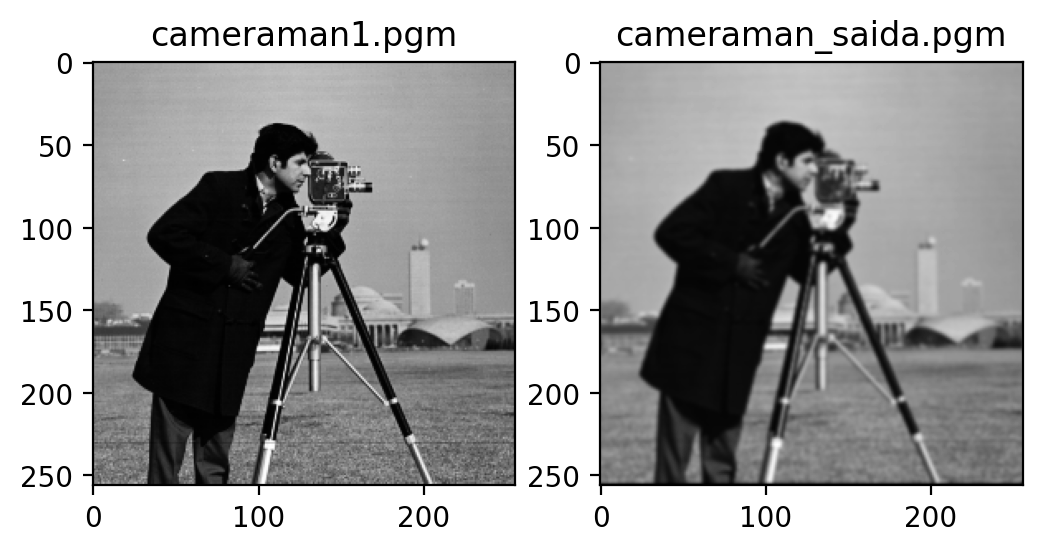

In [ ]:
input, output = args[0]
limpa_arquivos_de_saida()
! mpicc convolucao_mpi.c -lm -o convolucao_mpi && time mpirun --allow-run-as-root -n 17 -host localhost:17 convolucao_mpi $input $output

plotar_imagens((input, output))

### MPI Linhas:

#### Código:

In [ ]:
%%writefile convolucao_mpi_linhas.c
#include <stdio.h>
#include <math.h>
#include <stdlib.h>
#include <string.h>
#include <time.h>
#include "mpi.h"

struct info {
    int lin, lin_curr;
    int largura;
} t_info;

struct r_info {
    int lin, lin_curr;
    int largura;
} r_info;

void mpi_convolution(int altura, int largura, short int mask[25], unsigned char *original, unsigned char *resultado){  
    int i, j, aux_i, aux_j, ii, jj;
    int pixel_resultante;
    int p, q;


    for(i = 0; i < altura; i++){
        for(j = 0; j < largura; j++){
            pixel_resultante = 0;
            aux_i = i; 
            for(p = 0; p < 5; p++){
                aux_j = j;
                for(q = 0; q < 5; q++){
                    pixel_resultante += original[aux_i*largura + aux_j] * mask[p*5 + q];
                    aux_j++;
                }                    
                aux_i++;
            }
            //por estarmos utilizando uma matriz 5x5 de gauss, após a soma das multiplicações devemos dividir por 273
            resultado[i*largura + j] = pixel_resultante/273;
        }
    }
}


int main(int argc, char **argv){
    char *nome_imagem;
    char *nome_imagem_saida;
    char key[128];
    int i, j, largura, altura, max, pixel_resultante, threshold;

    /* -- MPI -- */
    int numtasks, rank;
    int t, result;
    /* -- MPI -- */


    if (argc != 3){
        printf("Erro, o programa deve receber o nome da imagem de entrada \n"
                "e um nome para imagem de saida.");
        return 0;
    }


    // matriz de convolução gaussiana
    //gaus 5x5
    short int mask[25] = {1,  4,  7,  4, 1, 
                          4, 16, 26, 16, 4, 
                          7, 26, 41, 26, 7, 
                          4, 16, 26, 16, 4, 
                          1,  4,  7,  4, 1};



    float etime;
    struct timespec inic, fim;
    clock_gettime(CLOCK_REALTIME, &inic);

    /* -- MPI -- */
    result = MPI_Init(&argc, &argv);
    if (result != MPI_SUCCESS) {
        fprintf(stderr, "Erro iniciando MPI: %d\n", result)/
        MPI_Abort(MPI_COMM_WORLD, result);
    }
    MPI_Comm_size(MPI_COMM_WORLD, &numtasks);
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);


    if (rank == 0) {
        setbuf(stdout,NULL);

        /* Pertencia a todos os procesos */
        FILE *imagem;
        nome_imagem = argv[1];
        nome_imagem_saida = argv[2];

        imagem = fopen(nome_imagem , "r") ; // Abre o arquivo no modo leitura
        if(imagem == NULL){ // Verifica se o arquivo existe e foi aberto
            printf("Erro na abertura do arquivo %s\n", nome_imagem);
            return 0;
        }

        // Le cabecalho
        fscanf(imagem, "%s", key);

        // Imagens PGM tem "P5" na primeira linha
        if(strcmp(key,"P5") != 0){
            printf("Arquivo precisa ser PGM!\n") ;
            fclose(imagem);
            return 0;
        }

        //Próximos valores do cabeçalho após P5 são: numero de colunas, numero de linhas, e valor máximo.
        fscanf(imagem, "%d %d %d", &largura, &altura, &max) ;

        // Matriz para guardar a imagem original
        // Utilizando o método de bordas "pretas"
        unsigned char *original;
        int n_col = largura+2;
        int n_row = altura+2;
        original = (unsigned char*) malloc(n_row * n_col * sizeof(unsigned char*));


        // Leitura da imagem original
        for(i = 1; i < altura+1; i++){
            for(j = 1; j < largura+1; j++){
                fscanf(imagem, "%c", &original[i*largura + j]);
            }
        }
        /* Pertencia a todos os procesos */
        
        int tamanho_secao_altura = altura / (numtasks - 1);
        int resto = altura % (numtasks - 1);

        t_info.lin_curr = 0;
        t_info.lin = tamanho_secao_altura + resto;
        t_info.largura = largura;

        MPI_Request requests[numtasks];

        /* Sending info to task 1 */
        MPI_Send ( &t_info, sizeof(t_info), MPI_INT, 1, 1, MPI_COMM_WORLD); 

        for (i = 0; i < t_info.lin + 4; i++)
            MPI_Send( &original[i*t_info.largura], t_info.largura, MPI_UNSIGNED_CHAR, 1, 2, MPI_COMM_WORLD);
            // MPI_Isend( &original[i*t_info.largura], t_info.largura, MPI_UNSIGNED_CHAR, 1, 2, MPI_COMM_WORLD, &requests[1]);
        /* Sending info to task 1 */

        /* Sending info to other tasks */
        t_info.lin_curr += t_info.lin;
        t_info.lin = tamanho_secao_altura;
        for (t = 2; t < numtasks; t++) {
            MPI_Send ( &t_info, sizeof(t_info), MPI_INT, t, 1, MPI_COMM_WORLD); 

            for (i = t_info.lin_curr; i < t_info.lin_curr + tamanho_secao_altura + 4; i++)
                MPI_Send( &original[i*t_info.largura], t_info.largura, MPI_UNSIGNED_CHAR, t, 2, MPI_COMM_WORLD);
                // MPI_Isend( &original[i*t_info.largura], t_info.largura, MPI_UNSIGNED_CHAR, t, 2, MPI_COMM_WORLD, &requests[t]);

            t_info.lin_curr += tamanho_secao_altura;
        }
        /* Sending info to other tasks */


        unsigned char *resultado;
        resultado = (unsigned char*) malloc(altura * largura *sizeof(unsigned char*));

        /* Async
        for (t = 0; t < numtasks; t++) {
            MPI_Wait(&requests[t], MPI_STATUS_IGNORE);
        }
        Async */

        for (t = 1; t < numtasks; t++){
            // Retorna parâmetros e offsets
            MPI_Recv( &r_info, sizeof(r_info), MPI_INT, t, 2, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
            // printf("Task %d recebeu os parametros de volta.\n", t);

            // Retorna as linhas da seção
            for ( i = r_info.lin_curr; i < r_info.lin_curr + r_info.lin; i++)
                MPI_Recv( &resultado[i * r_info.largura], r_info.largura, MPI_UNSIGNED_CHAR, t, 3, MPI_COMM_WORLD, MPI_STATUS_IGNORE);

        }

        clock_gettime(CLOCK_REALTIME, &fim);
        // tempo decorrido: elapsed time
        etime = (fim.tv_sec + fim.tv_nsec/1000000000.) - 
                (inic.tv_sec + inic.tv_nsec/1000000000.) ;

        printf("Tempo da convolução: %lf\n", etime);
        printf("Altura: %d\tLargura: %d\n", altura ,largura);

        // abrir nova imagem em modo de escrita e "copiar" o cabeçalho da imagem original
        FILE *nova_imagem;
        nova_imagem = fopen(nome_imagem_saida , "w");
        fprintf(nova_imagem,"P5\n%d %d\n%d\n", largura, altura, max);

        // escrever no arquivo resultado
        for (i = 0; i < altura ; i++){
            for (j = 0; j < largura; j++){
                fprintf(nova_imagem, "%c", resultado[i*largura + j]);
            }
        }
        
        fclose(imagem);
        fclose(nova_imagem);
        free(resultado);
        free(original);

    } else {
        MPI_Recv(&t_info, sizeof(t_info), MPI_INT, 0, 1, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
        unsigned char * linhas_imagem;
        linhas_imagem = (unsigned char*) malloc ((t_info.lin + 4) * t_info.largura * sizeof(unsigned char *));

        /* Received */
        // printf("Received lines: %d, curr_line: %d, width: %d\n", t_info.lin, t_info.lin_curr, t_info.largura);

        for ( i = 0; i < t_info.lin + 4; i++)
            MPI_Recv( &linhas_imagem[i * t_info.largura], t_info.largura, MPI_UNSIGNED_CHAR, 0, 2, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
        // printf("[*] -- Terminei de receber as linhas!!!\n");

        r_info.lin = t_info.lin;
        r_info.lin_curr = t_info.lin_curr;
        r_info.largura = t_info.largura;

        unsigned char * resultado;
        resultado = (unsigned char*) malloc (t_info.lin * t_info.largura * sizeof(unsigned char *));
        mpi_convolution(r_info.lin, r_info.largura, mask, linhas_imagem, resultado);
       
        // sending info back
        MPI_Send( &r_info, sizeof(r_info), MPI_INT, 0, 2, MPI_COMM_WORLD);

        // sending lines
        for (i = 0; i < t_info.lin; i++)
            MPI_Send( &resultado[i*r_info.largura], r_info.largura, MPI_UNSIGNED_CHAR, 0, 3, MPI_COMM_WORLD);

        free(linhas_imagem);
        free(resultado);
    }

    MPI_Finalize();
    /* -- MPI -- */


    return 0;
}


Writing convolucao_mpi_linhas.c


#### Execução:

Tempo da convolução: 0.236115
Altura: 256	Largura: 256

real	0m0.322s
user	0m0.193s
sys	0m0.112s


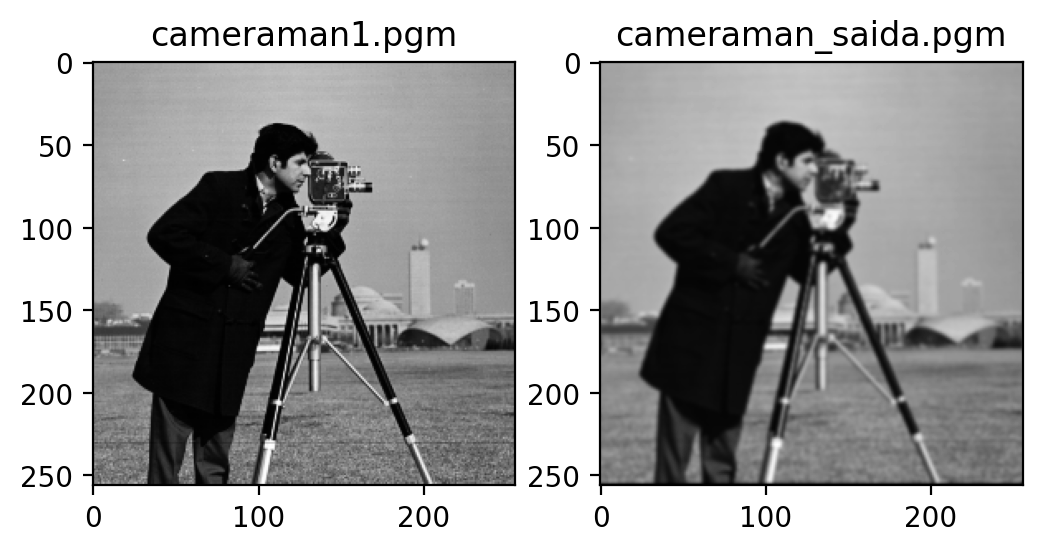

In [ ]:
input, output = args[0]
limpa_arquivos_de_saida()
! mpicc convolucao_mpi_linhas.c -o convolucao_mpi && time mpirun --allow-run-as-root -n 3 -host localhost:3 convolucao_mpi $input $output

plotar_imagens((input, output))

### Cuda:

####Código:

In [8]:
%%writefile convolucao_cuda.cu
#include <stdio.h>
#include <stdlib.h>
#include <string.h>

__global__
void convolution(int altura, int largura, short int *mask, unsigned char *original, unsigned char *resultado){  
    int i = blockIdx.y * blockDim.y + threadIdx.x;
    int j = blockIdx.x * blockDim.x + threadIdx.y;
    int aux_i, aux_j;
    int pixel_resultante;
    int p, q; // for interno, da mascara 3x3

    if (i >= altura || j >= largura){
        return;
    }

    pixel_resultante = 0;
    aux_i = i; 
    for(p = 0; p < 5; p++){
        aux_j = j;
        for(q = 0; q < 5; q++){
            pixel_resultante += original[aux_i*largura + aux_j] * mask[p*5 + q];
            aux_j++;
        }
        aux_i++;
    }
    //por estarmos utilizando uma matriz 5x5 de gauss, após a soma das multiplicações devemos dividir por 273
    resultado[i*largura + j] = pixel_resultante/273;
}

int main(int argc, char **argv){
    FILE *imagem;
    FILE *nova_imagem;
    char *nome_imagem;
    char *nome_imagem_saida;
    char key[128];
    int i, j, largura, altura, max;
    float etime;
    struct timespec inic, fim;

    if (argc != 3){
        printf("Erro, o programa deve receber o nome da imagem de entrada \n"
                "e um nome para imagem de saida.");
        return 0;
    }

    nome_imagem = argv[1];
    nome_imagem_saida = argv[2];

    imagem = fopen(nome_imagem , "r") ; // Abre o arquivo no modo leitura
    if(imagem == NULL){ // Verificase o arquivo existe e foi aberto
        printf("Erro na abertura do arquivo %s\n", nome_imagem);
        return 0;
    }

    // Le cabecalho
    fscanf(imagem, "%s", key);

    // Imagens PGM tem "P5" na primeira linha
    if(strcmp(key,"P5") != 0){
        printf("Arquivo precisa ser PGM!\n") ;
        fclose(imagem);
        return 0;
    }

    //Próximos valores do cabeçalho após P5 são: numero de colunas, numero de linhas, e valor máximo.
    fscanf(imagem, "%d %d %d", &largura, &altura, &max) ;

    // Matriz para guardar a imagem original
    // Utilizando o método de bordas "pretas"
    unsigned char *original, *d_original;
    int n_col = largura+2;
    int n_row = altura+2;
    
    original = (unsigned char*) malloc(n_row * n_col * sizeof(unsigned char*));
    // Matriz pra servir de buffer pra imagem resultado
    unsigned char *resultado, *d_resultado;
    resultado = (unsigned char*) malloc(altura * largura *sizeof(unsigned char*));

    // Leitura da imagem original
    for(i = 1; i < altura+1; i++){
        for(j = 1; j < largura+1; j++){
            fscanf(imagem, "%c", &original[i*largura + j]);
        }
    }

    //gaus 5x5
    short int mask[25] = {1,  4,  7,  4, 1, 
                          4, 16, 26, 16, 4, 
                          7, 26, 41, 26, 7, 
                          4, 16, 26, 16, 4, 
                          1,  4,  7,  4, 1};

    // para calcular uma imagem inteira, 256x256 precisamos de um grid 8x8 (8x32 =256)
    // o x indica o calculo dos pixeis na horizontal e o y na vertical
    // como o valor máximo de threads por bloco são travados em 1024 manteremos o dim3 block com valores travados (em 1024) e 
    // alteraremos o valor do grid conforme o MxN pego na leitura do arquivo.
    dim3 grid(largura/32,altura/32);
    dim3 block(32,32);
    

    clock_gettime(CLOCK_REALTIME, &inic);
    
    cudaMalloc(&d_original, n_row * n_col * sizeof(unsigned char*));
    cudaMalloc(&d_resultado, n_row * n_col * sizeof(unsigned char*));

    cudaMemcpy(d_original, original, altura * largura *sizeof(unsigned char*), cudaMemcpyHostToDevice);

    short int *d_mask;
    cudaMalloc(&d_mask, 5 * 5 * sizeof(short int*));
    cudaMemcpy(d_mask, mask, 5 * 5 * sizeof(short int*), cudaMemcpyHostToDevice);

    convolution<<<grid,block>>>(altura, largura, d_mask, d_original, d_resultado);
    cudaMemcpy(resultado, d_resultado, altura * largura * sizeof(unsigned char*), cudaMemcpyDeviceToHost);
    const char *string_error = cudaGetErrorString(cudaGetLastError());
    cudaDeviceSynchronize();

    clock_gettime(CLOCK_REALTIME, &fim);

    // tempo decorrido: elapsed time
    etime = (fim.tv_sec + fim.tv_nsec/1000000000.) - 
            (inic.tv_sec + inic.tv_nsec/1000000000.) ;

    printf("Tempo da convolução: %lf\n", etime);
    printf("Altura: %d\tLargura: %d\n", altura ,largura);
    

    if(strcmp(string_error,"no error") != 0){
      printf("Device Variable Copying:\t%s\n", string_error);
    }
    // abrir nova imagem em modo de escrita e "copiar" o cabeçalho da imagem original
    nova_imagem = fopen(nome_imagem_saida , "w");
    fprintf(nova_imagem,"P5\n%d %d\n %d\n", largura, altura, max);

    // escrever no arquivo resultado
    for (i = 0; i < altura ; i++){
        for (j = 0; j < largura; j++){
            fprintf(nova_imagem, "%c", resultado[i*largura + j]);
        }
    }
    
    
    //fputs(resultado, nova_imagem);



    fclose(imagem);
    fclose(nova_imagem);

    free(original);
    free(resultado);

    cudaFree(d_mask);
    cudaFree(d_original);
    cudaFree(d_resultado);

    return 0;
}

Writing convolucao_cuda.cu


####Execução:

Tempo da convolução: 0.589469
Altura: 4320	Largura: 7680

real	0m3.398s
user	0m2.968s
sys	0m0.416s


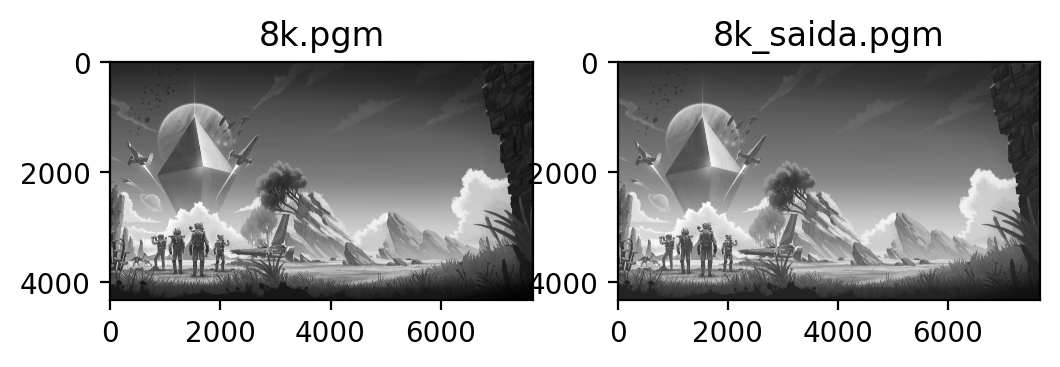

In [22]:
input, output = args[3]
limpa_arquivos_de_saida()
# 
! nvcc convolucao_cuda.cu -gencode arch=compute_37,code=sm_37 -Wno-deprecated-gpu-targets  -o convolucao_cuda.o && time ./convolucao_cuda.o $input $output

plotar_imagens((input, output))

### Comparação entre as execuções de Cuda e Sequencial

#### Média entre 10 execuções de cada tipo para cada imagem, e geração de um gráfico comparativo

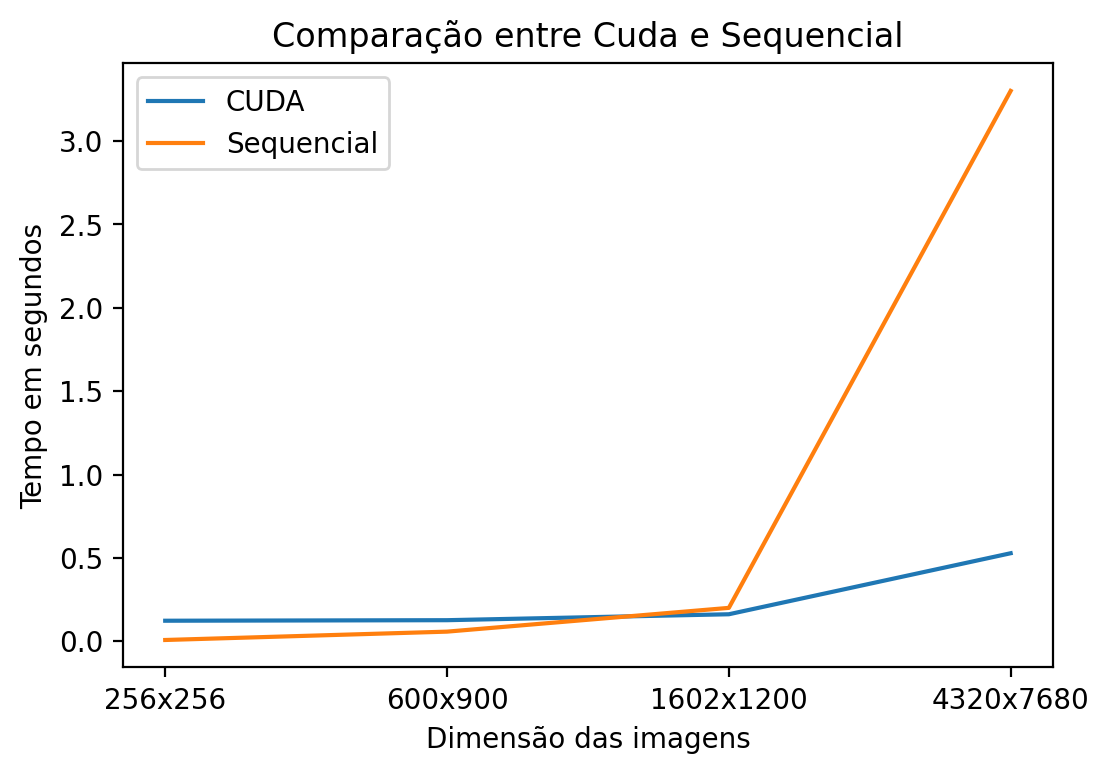

In [67]:
from typing import List

!gcc convolucao_seq.c -o seq.o 
!nvcc convolucao_cuda.cu -gencode arch=compute_37,code=sm_37 -Wno-deprecated-gpu-targets -o convolucao_cuda.o 


def get_dimensao(stdout: List[str]) -> str:
  """
  Trata a saida do código em C, retornando a dimensando como NxN
  """
  dim = stdout[1].split('\t')
  altura = dim[0].split(': ')[-1]
  largura = dim[1].split(': ')[-1]
  return f'{altura}x{largura}'

def get_tempo(stdout: List[str]) -> float:
  """
  Trata a saida do código em C, splitando no Tempo de Convolução: 
  """
  tempo = float(stdout[0].split(': ')[-1])
  return tempo


def get_media(objeto: str, input: str, output: str):
  """
  Recebe uma string contendo o objeto a ser executado, imagens de input e output
  Executa 10x e tira a média do tempo de convolução
  """
  media = 0
  execucao1 = !  $objeto $input $output
  media += get_tempo(execucao1)
  dimensao = get_dimensao(execucao1)
  for i in range(9):
    execucao = !  $objeto $input $output
    media += get_tempo(execucao)
  return media/10, dimensao


resultados_cuda = []
resultados_seq = []
eixo_x = []
for arg in args:
  seq = get_media("./seq.o", *arg)
  cuda = get_media("./convolucao_cuda.o", *arg)
  eixo_x.append(seq[1]) # dimensao das imagens
  resultados_cuda.append(cuda[0])
  resultados_seq.append(seq[0])

import matplotlib.pyplot as plt
plt.figure(dpi=200)
plt.plot(eixo_x, resultados_cuda, label="CUDA")
plt.plot(eixo_x, resultados_seq, label="Sequencial")
plt.title("Comparação entre Cuda e Sequencial")
plt.ylabel("Tempo em segundos")
plt.xlabel("Dimensão das imagens")
plt.legend()
plt.show()




###Visualização das informações do device:

In [9]:
%%writefile max-dims.cu

#include <stdio.h>

int main(void)
{
	cudaSetDevice(0);
	cudaDeviceProp prop;
	cudaGetDeviceProperties(&prop,0);
 	
 	printf("Modelo do Device: %s\n",prop.name);
  printf("Número de SMs: %d\n",prop.multiProcessorCount);
  
 	printf("\nmaxGridSize: %d, %d, %d\n",prop.maxGridSize[0],
         prop.maxGridSize[1],prop.maxGridSize[2]);
 	printf("maxThreadsDim: %d, %d, %d\n",prop.maxThreadsDim[0],
         prop.maxThreadsDim[1],prop.maxThreadsDim[2]);
  printf("maxThreadsPerBlock: %d\n",prop.maxThreadsPerBlock);
  printf("maxThreadsPerMultiProcessor: %d\n",prop.maxThreadsPerMultiProcessor);

	return 0;
}

Writing max-dims.cu


In [10]:
! nvcc max-dims.cu -o max-dims && ./max-dims

Modelo do Device: Tesla K80
Número de SMs: 13

maxGridSize: 2147483647, 65535, 65535
maxThreadsDim: 1024, 1024, 64
maxThreadsPerBlock: 1024
maxThreadsPerMultiProcessor: 2048
